### Carga de datos

In [2]:
import pandas as pd
import numpy as np

# Establecer la semilla aleatoria para NumPy
np.random.seed(40)

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Entrenamiento del modelo

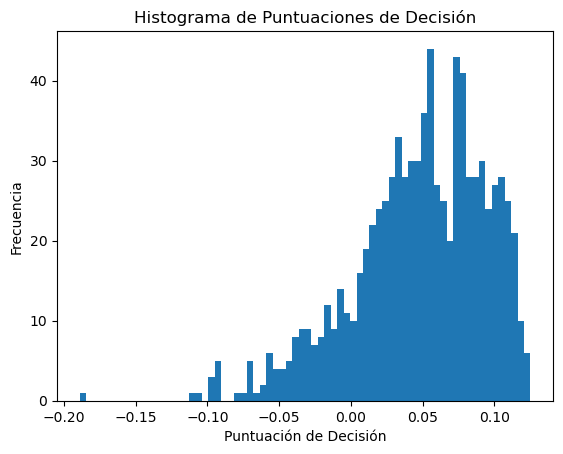

In [3]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Inicializa el modelo Isolation Forest
iForest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42) 

# Ajusta el modelo a los datos
iForest.fit(data_train)

# Calcula las puntuaciones de anomalía para cada observación
scores_train = iForest.decision_function(data_train)

plt.hist(scores_train, bins=70)
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

C:\Users\djime\AppData\Local\Temp\ipykernel_5112\2849368235.py:17: RuntimeWarning: invalid value encountered in scalar divide
  PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)


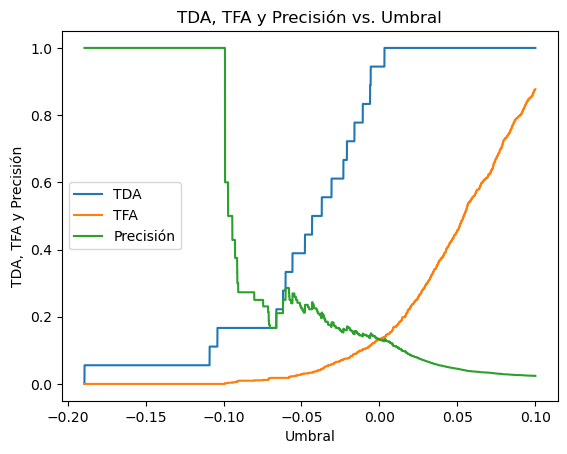

In [4]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(scores_train), 0.1, 0.000004)
tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(scores_train < umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)

plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
plt.show()

### Selección del valor de TFA/TDA=1 

(min TFA)/TDA=1: 0.1398


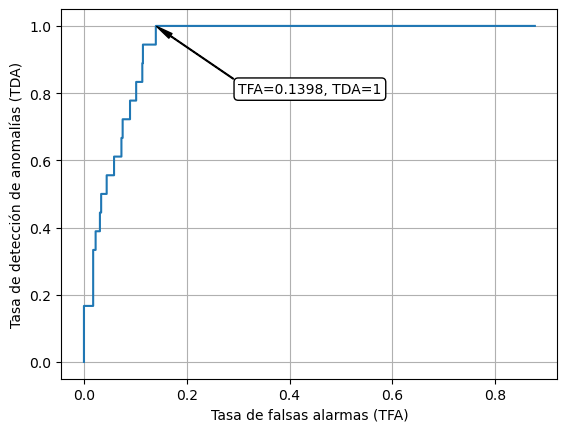

In [5]:
# Encontrar el menor valor de TFA cuando TDA es igual a 1
min_tfa = min([tfa[j] for j in range(len(tda)) if tda[j] == 1], default=np.nan)
print(f'(min TFA)/TDA=1: {min_tfa:.4f}')

plt.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)

# Agregar una etiqueta en (0.3, 0.8)
plt.annotate(f'TFA={min_tfa:.4f}, TDA=1', xy=(min_tfa, 1), xytext=(0.3, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.01, width=0.5, headwidth=4),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [6]:
from sklearn.metrics import classification_report

valor_tfa=min_tfa 
valor_tda=1

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")

anomalias = data_train[scores_train < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_train < umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Umbral para la decisión: 0.003182446987676779
-----------------------------------------------------------------------
Número de anomalías detectadas: 135
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       837
           1       0.13      1.00      0.24        18

    accuracy                           0.86       855
   macro avg       0.57      0.93      0.58       855
weighted avg       0.98      0.86      0.91       855

------------------------------------------------------------------------
[[720 117]
 [  0  18]]
VP: 18
FP: 117
VN: 720
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.13978494623655913
Precision: 0.13333333333333333
Especificidad 0.8602150537634409
F1: 0.23529411764705882


### Análisis y resultados en la validación (data_test)

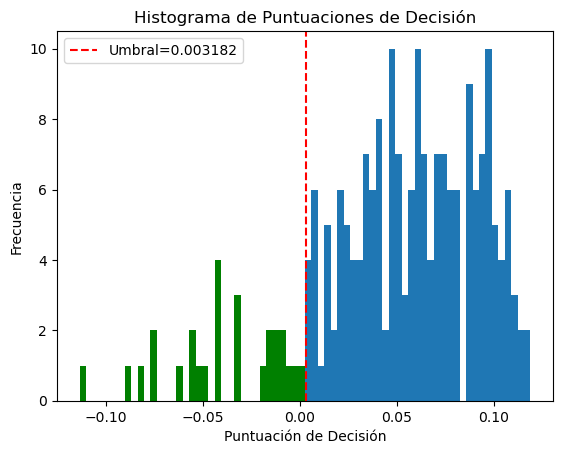

Número de anomalías detectadas: 27
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       204
           1       0.37      1.00      0.54        10

    accuracy                           0.92       214
   macro avg       0.69      0.96      0.75       214
weighted avg       0.97      0.92      0.94       214

------------------------------------------------------------------------
[[187  17]
 [  0  10]]
VP: 10
FP: 17
VN: 187
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.08333333333333333
Precision: 0.37037037037037035
Especificidad 0.9166666666666666
F1: 0.5405405405405406


In [33]:
scores_test = iForest.decision_function(data_test)

counts, bins = np.histogram(scores_test, bins=70)
colors = ['#008000' if (bin + np.diff(bins)[0] / 2) < umbral_dec else '#1f77b4' for bin in bins[:-1]]
plt.bar(bins[:-1], counts, width=np.diff(bins), color=colors, align='edge')
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.axvline(x=umbral_dec, color='red', linestyle='--', linewidth=1.5, label=f'Umbral={umbral_dec:.6f}')
plt.legend()
plt.show()

anomalias = data_test[scores_test < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_test < umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1] 
FP = cm[0, 1] 
VN = cm[0, 0] 
FN = cm[1, 0]
print("VP:",VP) 
print("FP:",FP) 
print("VN:",VN) 
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN) 
TFA=FP/(VN+FP) 
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

#### Graficar el umbral

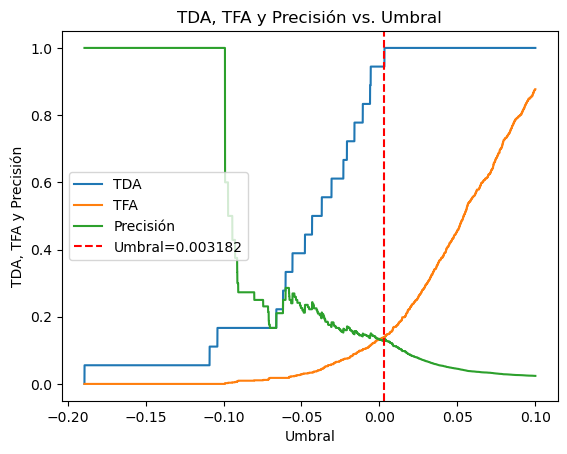

In [31]:
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=1.5, label=f'Umbral={umbral_dec:.6f}')
plt.legend()
plt.show()

### Ajuste fino del umbral
#### Umbral definitivo Umbral=0.003182